# Question 1

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
import random
import numpy as np
import matplotlib.pyplot as plt

# set the range of sample sizes
n_range = range(10, 10001, 10)

# initialize arrays to store the estimated values and confidence intervals
pi_estimates = np.zeros(len(n_range))
lower_bounds = np.zeros(len(n_range))
upper_bounds = np.zeros(len(n_range))

# loop over the sample sizes
for i, n in enumerate(n_range):
    # generate n random points within a square of side length 2
    points = np.random.uniform(-1, 1, size=(n, 2))
    # count the number of points within a quarter circle of radius 1
    n_in_circle = np.sum(np.linalg.norm(points, axis=1) <= 1)
    # estimate the value of pi
    pi_estimates[i] = 4 * n_in_circle / n
    # calculate the standard error and 95% confidence interval
    std_est = np.std(pi_estimates[:i+1], ddof=1)
    margin_error = 1.96 * std_est / np.sqrt(i+1)
    lower_bounds[i] = pi_estimates[i] - margin_error
    upper_bounds[i] = pi_estimates[i] + margin_error



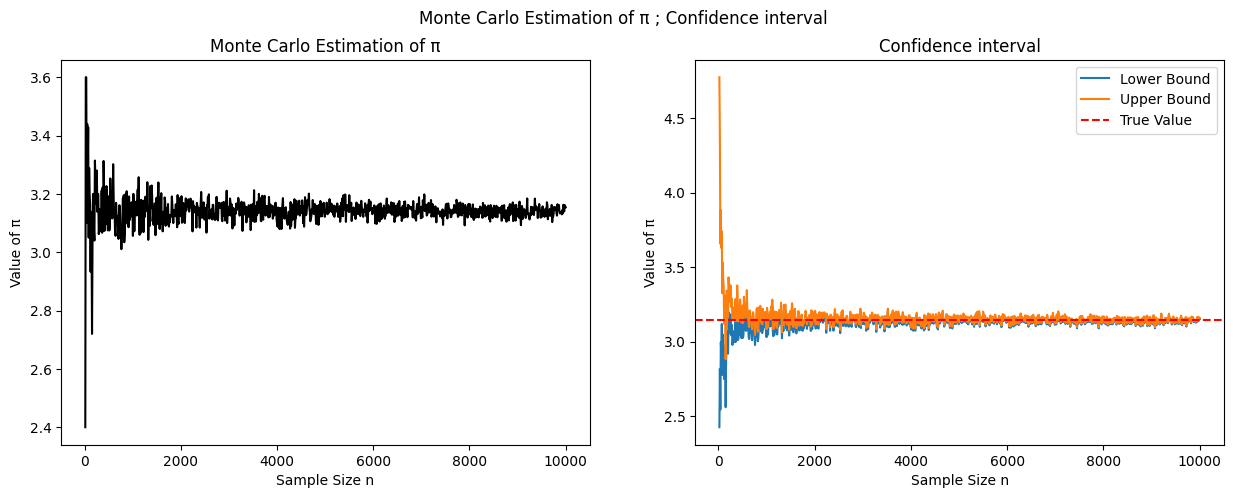

Estimator for n = 10000: 3.1540
Margin of error for n = 10000: 0.0030


In [40]:
plt.figure(figsize=(15,5))
plt.suptitle("Monte Carlo Estimation of π ; Confidence interval")
# plot the evolution of the estimator and confidence interval
plt.subplot(1,2,1)
plt.plot(n_range, pi_estimates,'black', label='Estimator')
plt.title('Monte Carlo Estimation of π')
plt.xlabel('Sample Size n')
plt.ylabel('Value of π')

plt.subplot(1,2,2)
plt.plot(n_range, lower_bounds, label='Lower Bound')
plt.plot(n_range, upper_bounds, label='Upper Bound')
plt.axhline(y=np.pi, color='r', linestyle='--', label='True Value')
plt.xlabel('Sample Size n')
plt.ylabel('Value of π')
plt.title('Confidence interval')
plt.legend()
plt.show()

# print the estimator and margin of error for n = 10,000
print(f"Estimator for n = 10000: {pi_estimates[-1]:.4f}")
print(f"Margin of error for n = 10000: {upper_bounds[-1] - pi_estimates[-1]:.4f}")


# Question 2

### a. Simulate n = 10, 000 paths of the stock price and create a histogram of the discounted hedging error as a fraction of the price of the option for both weekly (m = 13) and daily (m = 63) rebalancing. Also report the means and the standard deviations. Comment on your findings; are they in line with theory?

Daily: mean -0.00322779542946003 std 0.3322215108057597
Weekly: mean 0.00038086357326290834 std 0.3226618042164149

They are not in line with theory
Weekly is higher than daily for mean and lower for std. It is closer to 0.
With lower hedging times, the absolute value of hedging error is lower.

In [41]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from matplotlib import pyplot as plt
from math import log, sqrt, pi, exp
from scipy import stats

In [42]:
#bs model 
def bsprice(s0,k,T,r,sig):
    d1 = (np.log(s0 / k) + (r + 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    d2 = d1 - sig * np.sqrt(T)
    option_price = s0 * stats.norm.cdf(d1) - k * np.exp(-r * T) * stats.norm.cdf(d2)
    return option_price
def bsdelta(s0,k,T,r,sig):
    d1 = (np.log(s0 / k) + (r + 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    delta = stats.norm.cdf(d1)
    return delta 

In [43]:
def stock_paths_daily(S0, mu, sigma, T, M, times):
    dt = float(T) / M # time step, 1 day
    paths = np.zeros((M + 1, times), np.float64)
    paths[0] = S0
    for t in range(1, M + 1):
        rand = np.random.standard_normal(times)
        paths[t] = paths[t - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt +
                                         sigma * np.sqrt(dt) * rand)
    return paths


In [44]:
def stock_paths_weekly(S0,mu,sigma,T,M,times):
    dt_weekly= float(T) /M
    paths = np.zeros((M2 + 1,times))
    paths[0] = S0
    for i in range(1, M2+1):
        paths[i] = paths[i - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt_weekly + sigma * np.sqrt(dt_weekly) * np.random.standard_normal(times))
    return paths

In [45]:
# simulate daily stock price in 3 month
s0 = 50 #initial stock price
k= 50 #strike price
mu = 0.1 
r = 0.05 #risk-free rate
sig = 0.3 #volatility in market
T = 0.25 #expiration time in years
M = 63 #number of steps within each simulation,63 trading days of 3 months
times = 10000
sigma1=0.02 #changed realized vol

In [46]:
#define PnL function daily
daily_paths=63
def delta_hedge_daily(mu,daily_paths,times,s0,sig):
    dt_daily = T /daily_paths
    def sp_paths_daily(s0,mu,sig,T,daily_paths,times):
        paths = np.zeros((daily_paths + 1,times))
        paths[0] = s0
        for i in range(1, daily_paths + 1):
            paths[i] = paths[i - 1] * np.exp((mu - 0.5 * sig ** 2) * dt_daily + sig * np.sqrt(dt_daily) * np.random.standard_normal(times))
        return paths
    sp_daily = sp_paths_daily(s0,mu,sig,T,daily_paths,times)
    initial_delta =  bsdelta(s0,k,T,r,sig)
    initial_shares_daily = initial_delta * 1 #sell one share of call option
    initial_cost_shares_daily = initial_shares_daily * s0
    initial_interest_daily = initial_cost_shares_daily * (np.exp(r*dt_daily)-1)
    initial_hedge_account_daily = initial_cost_shares_daily
    expire_time_daily = np.append((np.ones((daily_paths, 1)) * dt_daily).cumsum()[::-1],0)
    delta_daily = np.zeros((daily_paths + 1, times))
    shares_daily = np.zeros((daily_paths + 1, times))
    cost_shares_daily = np.zeros((daily_paths + 1, times))
    hedge_account_daily = np.zeros((daily_paths + 1, times))
    interest_daily = np.zeros((daily_paths, times))
    
    for simulation in range(times):
        for step in range(daily_paths + 1):
            delta_daily[0, simulation] = initial_delta
            shares_daily[0, simulation] = initial_shares_daily
            cost_shares_daily[0, simulation] = initial_cost_shares_daily
            interest_daily[0, simulation] = initial_interest_daily
            hedge_account_daily[0, simulation] = initial_cost_shares_daily 
            
            if step in range(1, daily_paths):
                delta_daily[step, simulation]=bsdelta(sp_daily[step,simulation],k,expire_time_daily[step],r,sig)
                shares_daily[step,simulation]=(delta_daily[step, simulation]-delta_daily[step-1, simulation])*1
                cost_shares_daily[step,simulation]=shares_daily[step,simulation]*sp_daily[step, simulation]
                hedge_account_daily[step, simulation]=hedge_account_daily[step-1, simulation]+interest_daily[step-1, simulation]+cost_shares_daily[step,simulation]
                interest_daily[step, simulation] = hedge_account_daily[step, simulation] * (np.exp(r*dt_daily)-1)
            if step == daily_paths:
                if sp_daily[step, simulation] > k:
                    delta_daily[step, simulation] = 1
                    shares_daily[step,simulation]=delta_daily[step, simulation]-delta_daily[step-1, simulation]
                    cost_shares_daily[step,simulation]=shares_daily[step,simulation]*sp_daily[step, simulation]
                    hedge_account_daily[step, simulation]=hedge_account_daily[step-1, simulation]+cost_shares_daily[step,simulation]+interest_daily[step-1, simulation]

                elif sp_daily[step, simulation] < k:
                    delta_daily[step, simulation] = 0
                    shares_daily[step,simulation] = delta_daily[step, simulation]-delta_daily[step - 1, simulation]
                    cost_shares_daily[step,simulation] = \
                    shares_daily[step,simulation] * sp_daily[step, simulation]
                    hedge_account_daily[step, simulation]=hedge_account_daily[step-1, simulation]+cost_shares_daily[step,simulation] + interest_daily[step-1, simulation]

                else:
                    delta_daily[step, simulation] = 0.5
                    shares_daily[step,simulation]=delta_daily[step, simulation] - delta_daily[step - 1, simulation]
                    cost_shares_daily[step,simulation]=shares_daily[step,simulation] * sp_daily[step, simulation]
                    hedge_account_daily[step, simulation] = hedge_account_daily[step-1, simulation]+cost_shares_daily[step,simulation] + interest_daily[step-1, simulation]
    delta_daily = pd.DataFrame(delta_daily)
    shares_daily = pd.DataFrame(shares_daily)
    cost_shares_daily = pd.DataFrame(cost_shares_daily)
    hedge_account_daily = pd.DataFrame(hedge_account_daily)
    interest_daily = pd.DataFrame(interest_daily)

    cum_cost_daily = hedge_account_daily.iloc[-1]
    pnl_daily = np.zeros((1,times))
    for i in range(0,times):
        if sp_daily[daily_paths,i] >= k:
            pnl_daily[0,i] = bsprice(s0,k,T,r,sig)*np.exp(r*T) - (cum_cost_daily[i]- k)
        elif sp_daily[daily_paths,i] < k:
            pnl_daily[0,i] = bsprice(s0,k,T,r,sig)*np.exp(r*T) - cum_cost_daily[i]
    df_pnl_daily = pd.DataFrame(pnl_daily)
    pnl_daily = df_pnl_daily.iloc[-1]
    return pnl_daily



In [47]:
pnl_daily_cal=delta_hedge_daily(mu,daily_paths,times,s0,sig)

<AxesSubplot:ylabel='Frequency'>

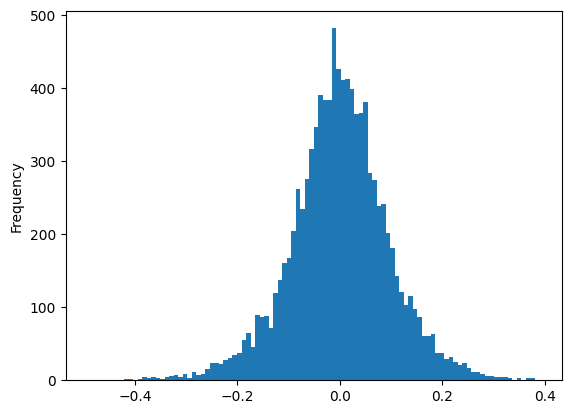

In [48]:
(pnl_daily_cal*np.exp(-r*T)/bsprice(s0,k,T,r,sig)).plot.hist(grid=False,bins=100)

In [49]:
np.mean(pnl_daily_cal)

-0.001627868477617568

In [50]:
np.std(pnl_daily_cal)

0.32469968865890186

In [51]:

weekly_paths=13
def delta_hedge_weekly(mu,weekly_paths,times,s0,sig):
    dt_weekly = T /weekly_paths
    def sp_paths_weekly(s0,mu,sig,T,weekly_paths,times):
        paths = np.zeros((weekly_paths + 1,times))
        paths[0] = s0
        for i in range(1, weekly_paths + 1):
            paths[i] = paths[i - 1] * np.exp((mu - 0.5 * sig ** 2) * dt_weekly + sig * np.sqrt(dt_weekly) * np.random.standard_normal(times))
        return paths
    sp_weekly = sp_paths_weekly(s0,mu,sig,T,weekly_paths,times)
    #initial setting weekly
    initial_delta =  bsdelta(s0,k,T,r,sig)
    initial_shares_weekly = initial_delta * 1 #sell one share of call option
    initial_cost_shares_weekly = initial_shares_weekly * s0
    initial_interest_weekly = initial_cost_shares_weekly * (np.exp(r*dt_weekly)-1)
    initial_hedge_account_weekly = initial_cost_shares_weekly
    expire_time_weekly = np.append((np.ones((weekly_paths, 1)) * dt_weekly).cumsum()[::-1],0)
    delta_weekly = np.zeros((weekly_paths + 1, times))
    shares_weekly = np.zeros((weekly_paths + 1, times))
    cost_shares_weekly = np.zeros((weekly_paths + 1, times))
    hedge_account_weekly = np.zeros((weekly_paths + 1, times))
    interest_weekly = np.zeros((weekly_paths, times))
    
    #delta hedging weekly
    for simulation in range(times):
        for step in range(weekly_paths + 1):
            delta_weekly[0, simulation] = initial_delta
            shares_weekly[0, simulation] = initial_shares_weekly
            cost_shares_weekly[0, simulation] = initial_cost_shares_weekly
            interest_weekly[0, simulation] = initial_interest_weekly
            hedge_account_weekly[0, simulation] = initial_cost_shares_weekly 

            if step in range(1, weekly_paths):
                delta_weekly[step, simulation]=bsdelta(sp_weekly[step,simulation],k,expire_time_weekly[step],r,sig)
                shares_weekly[step,simulation]=(delta_weekly[step, simulation]-delta_weekly[step-1, simulation])*1
                cost_shares_weekly[step,simulation]=shares_weekly[step,simulation]*sp_weekly[step, simulation]
                hedge_account_weekly[step, simulation]=hedge_account_weekly[step-1, simulation]+interest_weekly[step-1, simulation]+cost_shares_weekly[step,simulation]
                interest_weekly[step, simulation] = hedge_account_weekly[step, simulation] * (np.exp(r*dt_weekly)-1)
            if step == weekly_paths:
                if sp_weekly[step, simulation] > k:
                    delta_weekly[step, simulation] = 1
                    shares_weekly[step,simulation]=delta_weekly[step, simulation]-delta_weekly[step-1, simulation]
                    cost_shares_weekly[step,simulation]=shares_weekly[step,simulation]*sp_weekly[step, simulation]
                    hedge_account_weekly[step, simulation]=hedge_account_weekly[step-1, simulation]+cost_shares_weekly[step,simulation]+interest_weekly[step-1, simulation]

                elif sp_weekly[step, simulation] < k:
                    delta_weekly[step, simulation] = 0
                    shares_weekly[step,simulation] = delta_weekly[step, simulation]-delta_weekly[step - 1, simulation]
                    cost_shares_weekly[step,simulation] = \
                    shares_weekly[step,simulation] * sp_weekly[step, simulation]
                    hedge_account_weekly[step, simulation]=hedge_account_weekly[step-1, simulation]+cost_shares_weekly[step,simulation] + interest_weekly[step-1, simulation]

                else:
                    delta_weekly[step, simulation] = 0.5
                    shares_weekly[step,simulation]=delta_weekly[step, simulation] - delta_weekly[step - 1, simulation]
                    cost_shares_weekly[step,simulation]=shares_weekly[step,simulation] * sp_weekly[step, simulation]
                    hedge_account_weekly[step, simulation] = hedge_account_weekly[step-1, simulation]+cost_shares_weekly[step,simulation] + interest_weekly[step-1, simulation]
    delta_weekly = pd.DataFrame(delta_weekly)
    shares_weekly = pd.DataFrame(shares_weekly)
    cost_shares_weekly = pd.DataFrame(cost_shares_weekly)
    hedge_account_weekly = pd.DataFrame(hedge_account_weekly)
    interest_weekly = pd.DataFrame(interest_weekly)
    cum_cost_weekly = hedge_account_weekly.iloc[-1]
    pnl_weekly = np.zeros((1,times))
    for i in range(0,times):
        if sp_weekly[weekly_paths,i] >= k:
            pnl_weekly[0,i] = bsprice(s0,k,T,r,sig)*np.exp(r*T) - (cum_cost_weekly[i]- k)
        elif sp_weekly[weekly_paths,i] < k:
            pnl_weekly[0,i] = bsprice(s0,k,T,r,sig)*np.exp(r*T) - cum_cost_weekly[i]
    df_pnl_weekly = pd.DataFrame(pnl_weekly)
    pnl_weekly = df_pnl_weekly.iloc[-1]
    return pnl_weekly

In [52]:
pnl_weekly_cal=delta_hedge_weekly(mu,daily_paths,times,s0,sig)

<AxesSubplot:ylabel='Frequency'>

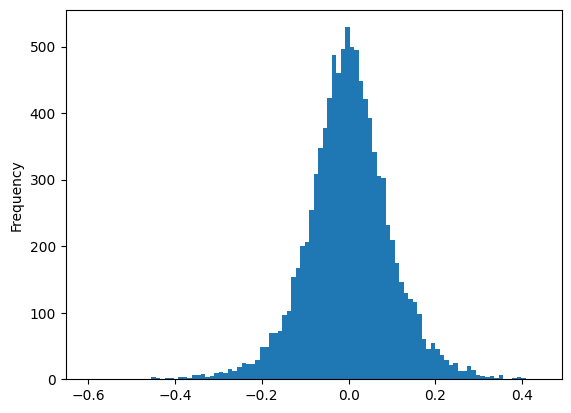

In [53]:
(pnl_weekly_cal*np.exp(-r*T)/bsprice(s0,k,T,r,sig)).plot.hist(grid=False,bins=100)

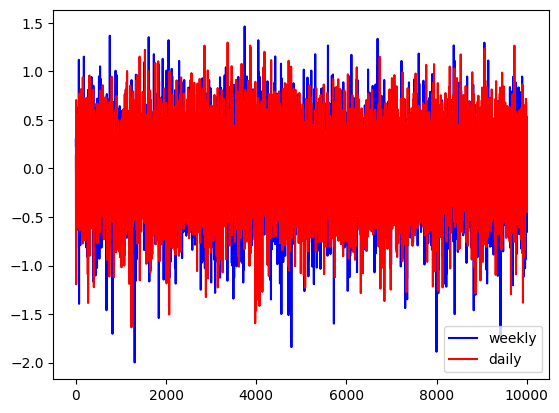

In [54]:
plt.plot(pnl_weekly_cal,'b',label='weekly')
plt.plot(pnl_daily_cal,'r',label='daily')
plt.legend()

In [55]:
np.mean(pnl_weekly_cal)

-0.0007235774804875214

In [56]:
np.std(pnl_weekly_cal)

0.32876554339940195

### (b) Consider values of μ ranging from r to 1 and plot the mean and standard deviation of the hedging error as a function of μ. Use n = 10,000 and consider weekly (m = 13) and daily (m = 63) rebalancing. How does the value of μ impact the hedging errors? Comment on your findings; are they in line with theory?¶

With higher mu, the lower for both mean and std. They are in line with theroy. Daily is close to 0.
Daily  -0.016880234233017485 0.013626784000415337
Weekly -0.0801947758054306  0.06644970545300573

In [57]:
#define PnL function daily
daily_paths=63
def pnlerror_daily(mu,daily_paths,times,s0,sig):
    dt_daily = T /daily_paths
    def sp_paths_daily(s0,mu,sig,T,daily_paths,times):
        paths = np.zeros((daily_paths + 1,times))
        paths[0] = s0
        for i in range(1, daily_paths + 1):
            paths[i] = paths[i - 1] * np.exp((mu - 0.5 * sig ** 2) * dt_daily + sig * np.sqrt(dt_daily) * np.random.standard_normal(times))
        return paths
    sp_daily = sp_paths_daily(s0,mu,sig,T,daily_paths,times)
    initial_delta =  bsdelta(s0,k,T,r,sig)
    initial_shares_daily = initial_delta * 1 #sell one share of call option
    initial_cost_shares_daily = initial_shares_daily * s0
    initial_interest_daily = initial_cost_shares_daily * (np.exp(r*dt_daily)-1)
    initial_hedge_account_daily = initial_cost_shares_daily
    expire_time_daily = np.append((np.ones((daily_paths, 1)) * dt_daily).cumsum()[::-1],0)
    delta_daily = np.zeros((daily_paths + 1, times))
    shares_daily = np.zeros((daily_paths + 1, times))
    cost_shares_daily = np.zeros((daily_paths + 1, times))
    hedge_account_daily = np.zeros((daily_paths + 1, times))
    interest_daily = np.zeros((daily_paths, times))
    
    for simulation in range(times):
        for step in range(daily_paths + 1):
            delta_daily[0, simulation] = initial_delta
            shares_daily[0, simulation] = initial_shares_daily
            cost_shares_daily[0, simulation] = initial_cost_shares_daily
            interest_daily[0, simulation] = initial_interest_daily
            hedge_account_daily[0, simulation] = initial_cost_shares_daily 
            
            if step in range(1, daily_paths):
                delta_daily[step, simulation]=bsdelta(sp_daily[step,simulation],k,expire_time_daily[step],r,sig)
                shares_daily[step,simulation]=(delta_daily[step, simulation]-delta_daily[step-1, simulation])*1
                cost_shares_daily[step,simulation]=shares_daily[step,simulation]*sp_daily[step, simulation]
                hedge_account_daily[step, simulation]=hedge_account_daily[step-1, simulation]+interest_daily[step-1, simulation]+cost_shares_daily[step,simulation]
                interest_daily[step, simulation] = hedge_account_daily[step, simulation] * (np.exp(r*dt_daily)-1)
            if step == daily_paths:
                if sp_daily[step, simulation] > k:
                    delta_daily[step, simulation] = 1
                    shares_daily[step,simulation]=delta_daily[step, simulation]-delta_daily[step-1, simulation]
                    cost_shares_daily[step,simulation]=shares_daily[step,simulation]*sp_daily[step, simulation]
                    hedge_account_daily[step, simulation]=hedge_account_daily[step-1, simulation]+cost_shares_daily[step,simulation]+interest_daily[step-1, simulation]

                elif sp_daily[step, simulation] < k:
                    delta_daily[step, simulation] = 0
                    shares_daily[step,simulation] = delta_daily[step, simulation]-delta_daily[step - 1, simulation]
                    cost_shares_daily[step,simulation] = \
                    shares_daily[step,simulation] * sp_daily[step, simulation]
                    hedge_account_daily[step, simulation]=hedge_account_daily[step-1, simulation]+cost_shares_daily[step,simulation] + interest_daily[step-1, simulation]

                else:
                    delta_daily[step, simulation] = 0.5
                    shares_daily[step,simulation]=delta_daily[step, simulation] - delta_daily[step - 1, simulation]
                    cost_shares_daily[step,simulation]=shares_daily[step,simulation] * sp_daily[step, simulation]
                    hedge_account_daily[step, simulation] = hedge_account_daily[step-1, simulation]+cost_shares_daily[step,simulation] + interest_daily[step-1, simulation]
    delta_daily = pd.DataFrame(delta_daily)
    shares_daily = pd.DataFrame(shares_daily)
    cost_shares_daily = pd.DataFrame(cost_shares_daily)
    hedge_account_daily = pd.DataFrame(hedge_account_daily)
    interest_daily = pd.DataFrame(interest_daily)

    cum_cost_daily = hedge_account_daily.iloc[-1]
    pnl_daily = np.zeros((1,times))
    for i in range(0,times):
        if sp_daily[daily_paths,i] >= k:
            pnl_daily[0,i] = bsprice(s0,k,T,r,sig)*np.exp(r*T) - (cum_cost_daily[i]- k)
        elif sp_daily[daily_paths,i] < k:
            pnl_daily[0,i] = bsprice(s0,k,T,r,sig)*np.exp(r*T) - cum_cost_daily[i]
    df_pnl_daily = pd.DataFrame(pnl_daily)
    pnl_daily = df_pnl_daily.iloc[-1]
    return(pnl_daily.mean(),pnl_daily.std())

In [ ]:
mu = np.arange(0.05,1.05,0.05)
pnl_error_daily = np.zeros((2,len(mu)))
for j in range(len(mu)):
    pnl_error_daily[0,j] = pnlerror_daily(mu[j],daily_paths,times,s0,sig)[0]
    pnl_error_daily[1,j] = pnlerror_daily(mu[j],daily_paths,times,s0,sig)[1]
df_pnl_error_daily = pd.DataFrame(pnl_error_daily)
df_pnl_error_daily

In [156]:
np.mean(df_pnl_error_daily.iloc[0])

-0.016880234233017485

In [157]:
np.std(df_pnl_error_daily.iloc[0])

0.013626784000415337

In [5]:
# simulate daily stock price in 3 month
s0 = 50 #initial stock price
k= 50 #strike price
mu = 0.1 
r = 0.05 #risk-free rate
sig = 0.3 #volatility in market
T = 0.25 #expiration time in years
M = 63 #number of steps within each simulation,63 trading days of 3 months
times = 10000
sigma1=0.02 #changed realized vol

In [6]:
mu = np.arange(0.05,1.05,0.05)

In [7]:
#define PnL function daily
def pnlerror_weekly(mu,weekly_paths,times,s0,sig):
    dt_weekly = T / weekly_paths
    def sp_paths_weekly(s0,mu,sig,T,weekly_paths,times):
        paths = np.zeros((weekly_paths + 1,times))
        paths[0] = s0
        for i in range(1, weekly_paths + 1):
            paths[i] = paths[i - 1] * np.exp((mu - 0.5 * sig ** 2) * dt_weekly + sig * np.sqrt(dt_weekly) * np.random.standard_normal(times))
        return paths
    
    sp_weekly = sp_paths_weekly(s0,mu,sig,T,weekly_paths,times)
    
    #initial setting weekly
    initial_delta =  bsdelta(s0,k,T,r,sig) #delta0
    initial_shares_weekly = initial_delta * 1 #sell one share of call option
    initial_cost_shares_weekly = initial_shares_weekly * s0 #delta0*S0
    initial_interest_weekly = initial_cost_shares_weekly * (np.exp(r*dt_weekly)-1) #delta0*S0*r
    initial_hedge_account_weekly = initial_cost_shares_weekly
    
    expire_time_weekly = np.append((np.ones((weekly_paths, 1)) * dt_weekly).cumsum()[::-1],0)
    delta_weekly = np.zeros((weekly_paths + 1, times))
    shares_weekly = np.zeros((weekly_paths + 1, times))
    cost_shares_weekly = np.zeros((weekly_paths + 1, times))
    hedge_account_weekly = np.zeros((weekly_paths + 1, times))
    interest_weekly = np.zeros((weekly_paths, times))
    
    #delta hedging weekly
    for simulation in range(times):
        for step in range(weekly_paths + 1):
            delta_weekly[0, simulation] = initial_delta
            shares_weekly[0, simulation] = initial_shares_weekly
            cost_shares_weekly[0, simulation] = initial_cost_shares_weekly
            interest_weekly[0, simulation] = initial_interest_weekly
            hedge_account_weekly[0, simulation] = initial_cost_shares_weekly 

            if step in range(1, weekly_paths):
                delta_weekly[step, simulation]=bsdelta(sp_weekly[step,simulation],k,expire_time_weekly[step],r,sig)
                shares_weekly[step,simulation]=(delta_weekly[step, simulation]-delta_weekly[step-1, simulation])*1
                cost_shares_weekly[step,simulation]=shares_weekly[step,simulation]*sp_weekly[step, simulation]
                hedge_account_weekly[step, simulation]=hedge_account_weekly[step-1, simulation]+interest_weekly[step-1, simulation]+cost_shares_weekly[step,simulation]
                interest_weekly[step, simulation] = hedge_account_weekly[step, simulation] * (np.exp(r*dt_weekly)-1)
            if step == weekly_paths:
                if sp_weekly[step, simulation] > k:
                    delta_weekly[step, simulation] = 1
                    shares_weekly[step,simulation]=delta_weekly[step, simulation]-delta_weekly[step-1, simulation]
                    cost_shares_weekly[step,simulation]=shares_weekly[step,simulation]*sp_weekly[step, simulation]
                    hedge_account_weekly[step, simulation]=hedge_account_weekly[step-1, simulation]+cost_shares_weekly[step,simulation]+interest_weekly[step-1, simulation]

                elif sp_weekly[step, simulation] < k:
                    delta_weekly[step, simulation] = 0
                    shares_weekly[step,simulation] = delta_weekly[step, simulation]-delta_weekly[step - 1, simulation]
                    cost_shares_weekly[step,simulation] = \
                    shares_weekly[step,simulation] * sp_weekly[step, simulation]
                    hedge_account_weekly[step, simulation]=hedge_account_weekly[step-1, simulation]+cost_shares_weekly[step,simulation] + interest_weekly[step-1, simulation]

                else:
                    delta_weekly[step, simulation] = 0.5
                    shares_weekly[step,simulation]=delta_weekly[step, simulation] - delta_weekly[step - 1, simulation]
                    cost_shares_weekly[step,simulation]=shares_weekly[step,simulation] * sp_weekly[step, simulation]
                    hedge_account_weekly[step, simulation] = hedge_account_weekly[step-1, simulation]+cost_shares_weekly[step,simulation] + interest_weekly[step-1, simulation]
    delta_weekly = pd.DataFrame(delta_weekly)
    shares_weekly = pd.DataFrame(shares_weekly)
    cost_shares_weekly = pd.DataFrame(cost_shares_weekly)
    hedge_account_weekly = pd.DataFrame(hedge_account_weekly)
    interest_weekly = pd.DataFrame(interest_weekly)
    cum_cost_weekly = hedge_account_weekly.iloc[-1]
    pnl_weekly = np.zeros((1,times))
    for i in range(0,times):
        if sp_weekly[weekly_paths,i] >= k:
            pnl_weekly[0,i] = bsprice(s0,k,T,r,sig)*np.exp(r*T) - (cum_cost_weekly[i]- k)
        elif sp_weekly[weekly_paths,i] < k:
            pnl_weekly[0,i] = bsprice(s0,k,T,r,sig)*np.exp(r*T) - cum_cost_weekly[i]
    
    df_pnl_weekly = pd.DataFrame(pnl_weekly)
    pnl_weekly = df_pnl_weekly.iloc[-1]
    return (pnl_weekly.mean(),pnl_weekly.std())

In [8]:
weekly_paths=13

In [9]:
pnl_error_weekly = np.zeros((2,len(mu)))
for j in range(len(mu)):
    pnl_error_weekly[0,j] = pnlerror_weekly(mu[j],weekly_paths,times,s0,sig)[0]
    pnl_error_weekly[1,j] = pnlerror_weekly(mu[j],weekly_paths,times,s0,sig)[1]
df_pnl_error_weekly = pd.DataFrame(pnl_error_weekly)
df_pnl_error_weekly

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.007537,-0.000282,-0.008079,-0.012062,-0.007724,-0.012358,-0.029280,-0.046045,-0.051513,-0.063469,-0.065096,-0.082974,-0.106287,-0.111250,-0.129067,-0.133227,-0.154458,-0.180960,-0.194202,-0.208024
1,0.706618,0.698488,0.696305,0.688962,0.682908,0.690088,0.696902,0.679294,0.678364,0.680484,0.658816,0.647959,0.642578,0.632663,0.629987,0.611807,0.607970,0.597722,0.576604,0.582371


In [158]:
np.mean(df_pnl_error_weekly.iloc[0])

-0.0801947758054306

In [159]:
np.std(df_pnl_error_weekly.iloc[0])

0.06644970545300573

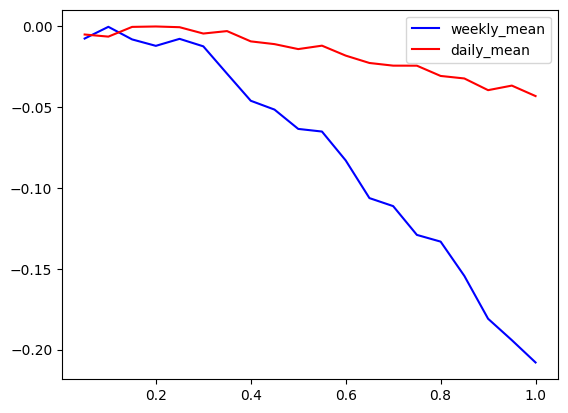

In [164]:
plt.plot(np.arange(0.05,1.05,0.05),df_pnl_error_weekly.iloc[0],'b',label='weekly_mean')
plt.plot(np.arange(0.05,1.05,0.05),df_pnl_error_daily.iloc[0],'r',label='daily_mean')
plt.legend()

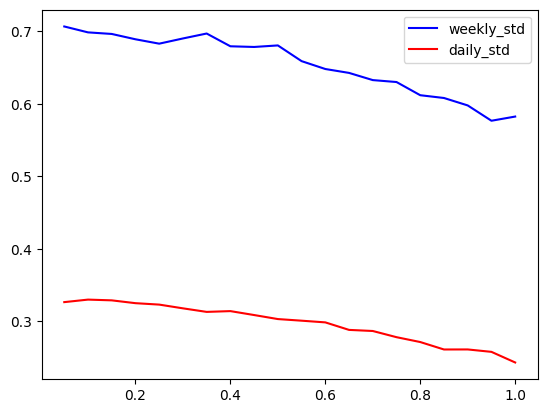

In [165]:
plt.plot(np.arange(0.05,1.05,0.05),df_pnl_error_weekly.iloc[1],'b',label='weekly_std')
plt.plot(np.arange(0.05,1.05,0.05),df_pnl_error_daily.iloc[1],'r',label='daily_std')
plt.legend()

In [10]:
pnlerror_weekly(0.1,13,times,s0,sig)[0]**2+pnlerror_weekly(0.1,13,times,s0,sig)[1]**2

0.4870322756613639

### c. Let ∆t denote the rebalancing interval. According to theory, the hedging error goes to zero as ∆t → 0. What do your simulation results indicate about the order of this convergence? Does the hedging error appear to be of order (∆t)α for some α > 0, and if so, what α?

α is 0.49 close to 0.5

In [11]:
def error_cal(a,b):
    lst=[]
    lst.append(np.sqrt(a**2+b**2))
    return lst

In [12]:
a1=error_cal(pnlerror_weekly(0.1,13,times,s0,sig)[0],pnlerror_weekly(0.1,13,times,s0,sig)[1])

In [13]:
a2=error_cal(pnlerror_weekly(0.1,63,times,s0,sig)[0],pnlerror_weekly(0.1,63,times,s0,sig)[1])

In [14]:
a3=error_cal(pnlerror_weekly(0.1,252,times,s0,sig)[0],pnlerror_weekly(0.1,252,times,s0,sig)[1])

In [15]:
a4=error_cal(pnlerror_weekly(0.1,1008,times,s0,sig)[0],pnlerror_weekly(0.1,1008,times,s0,sig)[1])

In [28]:
reg=[a1[0],a2[0],a3[0],a4[0]]
reg

[0.7045393838820767,
 0.3204035918849669,
 0.16200499020579645,
 0.08287889043999314]

In [29]:
delta_t=[0.25/13,0.25/63,0.25/252,0.25/1008]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.718e+04
Date:                Thu, 23 Mar 2023   Prob (F-statistic):           2.69e-05
Time:                        14:27:25   Log-Likelihood:                 14.904
No. Observations:                   4   AIC:                            -25.81
Df Residuals:                       2   BIC:                            -27.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5883      0.016     97.526      0.0

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


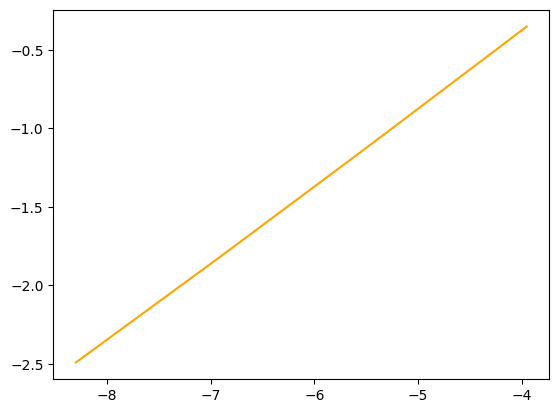

In [55]:
import numpy as np
import statsmodels.api as sm


x = np.log(delta_t)
y = np.log(reg)


X = sm.add_constant(x)


model = sm.OLS(y, X).fit()
#plt.scatter(x,y)
plt.plot(x,y,color = 'orange')

print(model.summary())


# Question 3

### (a) Assume σ = 0.3 and σR = 0.4. Repeat Problem 1(a) using (i) hedging with implied volatility and (ii) hedging with realized volatility. What does the hedging error look like? What is the impact of higher hedging frequency?

Daily  -0.9968562876634607 0.6045045906349529
Weekly -1.0135328380204238 1.0351438745248451

Higher frequency hedging will suffer less loss and have less std.

In [1]:
sigma1=0.4
sig=0.3
mu = 0.1 

In [122]:
daily_paths=63
def delta_hedge_daily_trading_vol(mu,daily_paths,times,s0,sig,sigma1):
    dt_daily = T /daily_paths
    def sp_paths_daily(s0,mu,sigma1,T,daily_paths,times):
        paths = np.zeros((daily_paths + 1,times))
        paths[0] = s0
        for i in range(1, daily_paths + 1):
            paths[i] = paths[i - 1] * np.exp((mu - 0.5 * sigma1 ** 2) * dt_daily + sigma1 * np.sqrt(dt_daily) * np.random.standard_normal(times))
        return paths
    
    sp_daily = sp_paths_daily(s0,mu,sigma1,T,daily_paths,times)
    initial_delta =  bsdelta(s0,k,T,r,sig)
    initial_shares_daily = initial_delta * 1 #sell one share of call option
    initial_cost_shares_daily = initial_shares_daily * s0
    initial_interest_daily = initial_cost_shares_daily * (np.exp(r*dt_daily)-1)
    initial_hedge_account_daily = initial_cost_shares_daily
    expire_time_daily = np.append((np.ones((daily_paths, 1)) * dt_daily).cumsum()[::-1],0)
    delta_daily = np.zeros((daily_paths + 1, times))
    shares_daily = np.zeros((daily_paths + 1, times))
    cost_shares_daily = np.zeros((daily_paths + 1, times))
    hedge_account_daily = np.zeros((daily_paths + 1, times))
    interest_daily = np.zeros((daily_paths, times))
    
    for simulation in range(times):
        for step in range(daily_paths + 1):
            delta_daily[0, simulation] = initial_delta
            shares_daily[0, simulation] = initial_shares_daily
            cost_shares_daily[0, simulation] = initial_cost_shares_daily
            interest_daily[0, simulation] = initial_interest_daily
            hedge_account_daily[0, simulation] = initial_cost_shares_daily 
            
            if step in range(1, daily_paths):
                delta_daily[step, simulation]=bsdelta(sp_daily[step,simulation],k,expire_time_daily[step],r,sig)
                shares_daily[step,simulation]=(delta_daily[step, simulation]-delta_daily[step-1, simulation])*1
                cost_shares_daily[step,simulation]=shares_daily[step,simulation]*sp_daily[step, simulation]
                hedge_account_daily[step, simulation]=hedge_account_daily[step-1, simulation]+interest_daily[step-1, simulation]+cost_shares_daily[step,simulation]
                interest_daily[step, simulation] = hedge_account_daily[step, simulation] * (np.exp(r*dt_daily)-1)
            if step == daily_paths:
                if sp_daily[step, simulation] > k:
                    delta_daily[step, simulation] = 1
                    shares_daily[step,simulation]=delta_daily[step, simulation]-delta_daily[step-1, simulation]
                    cost_shares_daily[step,simulation]=shares_daily[step,simulation]*sp_daily[step, simulation]
                    hedge_account_daily[step, simulation]=hedge_account_daily[step-1, simulation]+cost_shares_daily[step,simulation]+interest_daily[step-1, simulation]

                elif sp_daily[step, simulation] < k:
                    delta_daily[step, simulation] = 0
                    shares_daily[step,simulation] = delta_daily[step, simulation]-delta_daily[step - 1, simulation]
                    cost_shares_daily[step,simulation] = \
                    shares_daily[step,simulation] * sp_daily[step, simulation]
                    hedge_account_daily[step, simulation]=hedge_account_daily[step-1, simulation]+cost_shares_daily[step,simulation] + interest_daily[step-1, simulation]

                else:
                    delta_daily[step, simulation] = 0.5
                    shares_daily[step,simulation]=delta_daily[step, simulation] - delta_daily[step - 1, simulation]
                    cost_shares_daily[step,simulation]=shares_daily[step,simulation] * sp_daily[step, simulation]
                    hedge_account_daily[step, simulation] = hedge_account_daily[step-1, simulation]+cost_shares_daily[step,simulation] + interest_daily[step-1, simulation]
    delta_daily = pd.DataFrame(delta_daily)
    shares_daily = pd.DataFrame(shares_daily)
    cost_shares_daily = pd.DataFrame(cost_shares_daily)
    hedge_account_daily = pd.DataFrame(hedge_account_daily)
    interest_daily = pd.DataFrame(interest_daily)

    cum_cost_daily = hedge_account_daily.iloc[-1]
    pnl_daily = np.zeros((1,times))
    for i in range(0,times):
        if sp_daily[daily_paths,i] >= k:
            pnl_daily[0,i] = bsprice(s0,k,T,r,sig)*np.exp(r*T) - (cum_cost_daily[i]- k)
        elif sp_daily[daily_paths,i] < k:
            pnl_daily[0,i] = bsprice(s0,k,T,r,sig)*np.exp(r*T) - cum_cost_daily[i]
    df_pnl_daily = pd.DataFrame(pnl_daily)
    pnl_daily = df_pnl_daily.iloc[-1]
    return pnl_daily


In [123]:
pnl_daily_cal_trading_vol4=delta_hedge_daily_trading_vol(mu,daily_paths,times,s0,sig,0.4)

<AxesSubplot:ylabel='Frequency'>

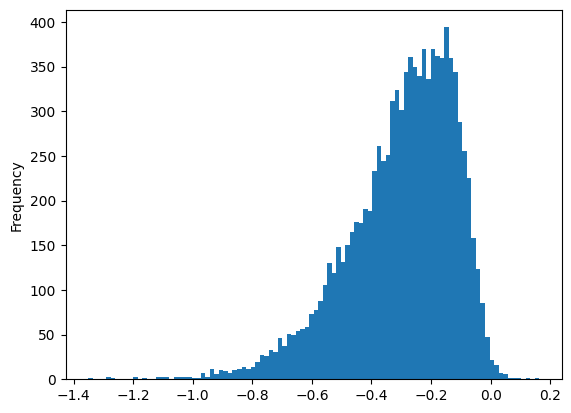

In [124]:
(pnl_daily_cal_trading_vol4*np.exp(-r*T)/bsprice(s0,k,T,r,sig)).plot.hist(grid=False,bins=100)

In [125]:
np.mean(pnl_daily_cal_trading_vol4)

-0.9968562876634607

In [126]:
np.std(pnl_daily_cal_trading_vol4)

0.6045045906349529

In [127]:
#define PnL function daily
weekly_paths=13
def delta_hedge_weekly_trading_vol(mu,weekly_paths,times,s0,sig,sigma1):
    dt_weekly = T /weekly_paths
    def sp_paths_weekly(s0,mu,sigma1,T,weekly_paths,times):
        paths = np.zeros((weekly_paths + 1,times))
        paths[0] = s0
        for i in range(1, weekly_paths + 1):
            paths[i] = paths[i - 1] * np.exp((mu - 0.5 *sigma1** 2) * dt_weekly + sigma1 * np.sqrt(dt_weekly) * np.random.standard_normal(times))
        return paths
    sp_weekly = sp_paths_weekly(s0,mu,sigma1,T,weekly_paths,times)
    #initial setting weekly
    initial_delta =  bsdelta(s0,k,T,r,sig)
    initial_shares_weekly = initial_delta * 1 #sell one share of call option
    initial_cost_shares_weekly = initial_shares_weekly * s0
    initial_interest_weekly = initial_cost_shares_weekly * (np.exp(r*dt_weekly)-1)
    initial_hedge_account_weekly = initial_cost_shares_weekly
    expire_time_weekly = np.append((np.ones((weekly_paths, 1)) * dt_weekly).cumsum()[::-1],0)
    delta_weekly = np.zeros((weekly_paths + 1, times))
    shares_weekly = np.zeros((weekly_paths + 1, times))
    cost_shares_weekly = np.zeros((weekly_paths + 1, times))
    hedge_account_weekly = np.zeros((weekly_paths + 1, times))
    interest_weekly = np.zeros((weekly_paths, times))
    
    #delta hedging weekly
    for simulation in range(times):
        for step in range(weekly_paths + 1):
            delta_weekly[0, simulation] = initial_delta
            shares_weekly[0, simulation] = initial_shares_weekly
            cost_shares_weekly[0, simulation] = initial_cost_shares_weekly
            interest_weekly[0, simulation] = initial_interest_weekly
            hedge_account_weekly[0, simulation] = initial_cost_shares_weekly 

            if step in range(1, weekly_paths):
                delta_weekly[step, simulation]=bsdelta(sp_weekly[step,simulation],k,expire_time_weekly[step],r,sig)
                shares_weekly[step,simulation]=(delta_weekly[step, simulation]-delta_weekly[step-1, simulation])*1
                cost_shares_weekly[step,simulation]=shares_weekly[step,simulation]*sp_weekly[step, simulation]
                hedge_account_weekly[step, simulation]=hedge_account_weekly[step-1, simulation]+interest_weekly[step-1, simulation]+cost_shares_weekly[step,simulation]
                interest_weekly[step, simulation] = hedge_account_weekly[step, simulation] * (np.exp(r*dt_weekly)-1)
            if step == weekly_paths:
                if sp_weekly[step, simulation] > k:
                    delta_weekly[step, simulation] = 1
                    shares_weekly[step,simulation]=delta_weekly[step, simulation]-delta_weekly[step-1, simulation]
                    cost_shares_weekly[step,simulation]=shares_weekly[step,simulation]*sp_weekly[step, simulation]
                    hedge_account_weekly[step, simulation]=hedge_account_weekly[step-1, simulation]+cost_shares_weekly[step,simulation]+interest_weekly[step-1, simulation]

                elif sp_weekly[step, simulation] < k:
                    delta_weekly[step, simulation] = 0
                    shares_weekly[step,simulation] = delta_weekly[step, simulation]-delta_weekly[step - 1, simulation]
                    cost_shares_weekly[step,simulation] = \
                    shares_weekly[step,simulation] * sp_weekly[step, simulation]
                    hedge_account_weekly[step, simulation]=hedge_account_weekly[step-1, simulation]+cost_shares_weekly[step,simulation] + interest_weekly[step-1, simulation]

                else:
                    delta_weekly[step, simulation] = 0.5
                    shares_weekly[step,simulation]=delta_weekly[step, simulation] - delta_weekly[step - 1, simulation]
                    cost_shares_weekly[step,simulation]=shares_weekly[step,simulation] * sp_weekly[step, simulation]
                    hedge_account_weekly[step, simulation] = hedge_account_weekly[step-1, simulation]+cost_shares_weekly[step,simulation] + interest_weekly[step-1, simulation]
    delta_weekly = pd.DataFrame(delta_weekly)
    shares_weekly = pd.DataFrame(shares_weekly)
    cost_shares_weekly = pd.DataFrame(cost_shares_weekly)
    hedge_account_weekly = pd.DataFrame(hedge_account_weekly)
    interest_weekly = pd.DataFrame(interest_weekly)
    cum_cost_weekly = hedge_account_weekly.iloc[-1]
    pnl_weekly = np.zeros((1,times))
    for i in range(0,times):
        if sp_weekly[weekly_paths,i] >= k:
            pnl_weekly[0,i] = bsprice(s0,k,T,r,sig)*np.exp(r*T) - (cum_cost_weekly[i]- k)
        elif sp_weekly[weekly_paths,i] < k:
            pnl_weekly[0,i] = bsprice(s0,k,T,r,sig)*np.exp(r*T) - cum_cost_weekly[i]
    df_pnl_weekly = pd.DataFrame(pnl_weekly)
    pnl_weekly = df_pnl_weekly.iloc[-1]
    return pnl_weekly

In [128]:
pnl_weekly_cal_trading_vol4=delta_hedge_weekly_trading_vol(mu,weekly_paths,times,s0,sig,0.4)

<AxesSubplot:ylabel='Frequency'>

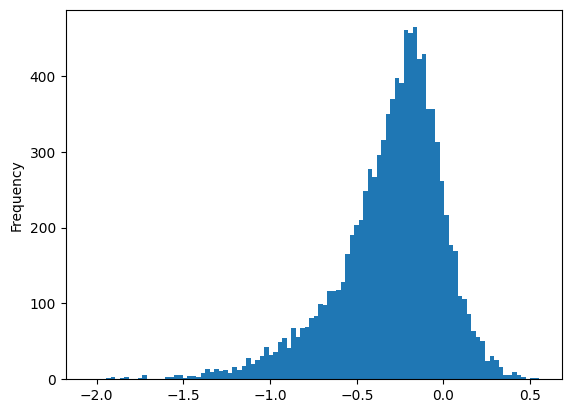

In [129]:
(pnl_weekly_cal_trading_vol4*np.exp(-r*T)/bsprice(s0,k,T,r,sig)).plot.hist(grid=False,bins=100)

In [130]:
np.mean(pnl_weekly_cal_trading_vol4)

-1.0135328380204238

In [131]:
np.std(pnl_weekly_cal_trading_vol4)

1.0351438745248451

### (b) Assume σ = 0.3 and σR = 0.2 and repeat part (a). How do the results change?

Daily 0.98956269206917 0.3763819730126598
Weekly 0.9900519089544081 0.5500692688042376 
Weekly hedging will have higher HE, and higher std.

In [132]:
sigma2=0.2
mu = 0.1 

In [133]:
pnl_daily_cal_trading_vol2=delta_hedge_daily_trading_vol(mu,daily_paths,times,s0,sig,0.2)

<AxesSubplot:ylabel='Frequency'>

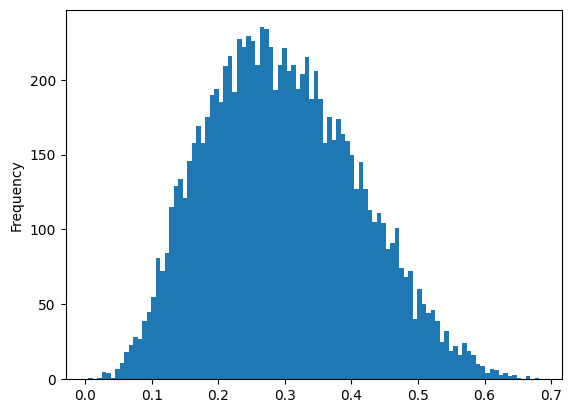

In [134]:
(pnl_daily_cal_trading_vol2*np.exp(-r*T)/bsprice(s0,k,T,r,sig)).plot.hist(grid=False,bins=100)

In [135]:
np.mean(pnl_daily_cal_trading_vol2)

0.98956269206917

In [136]:
np.std(pnl_daily_cal_trading_vol2)

0.3763819730126598

In [137]:
pnl_weekly_cal_trading_vol2=delta_hedge_weekly_trading_vol(mu,weekly_paths,times,s0,sig,0.2)

<AxesSubplot:ylabel='Frequency'>

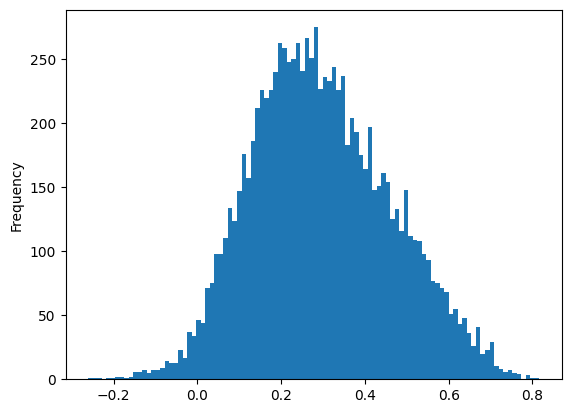

In [138]:
(pnl_weekly_cal_trading_vol2*np.exp(-r*T)/bsprice(s0,k,T,r,sig)).plot.hist(grid=False,bins=100)

In [139]:
np.mean(pnl_weekly_cal_trading_vol2)

0.9900519089544081

In [140]:
np.std(pnl_weekly_cal_trading_vol2)

0.5500692688042376

### (c) You are a trader and have a reason to believe that future realized volatility will be lower than the implied volatility indicated by the option price. Based on your results in parts (a) and (b), what is a viable trading strategy to benefit from this situation? What if you believe that future realized volatility will be higher than the implied volatility of the option?

I will use weekly delta hedging. And I will buy a straddle or strangle, which I could benefit from the vol no matter which side it envolves in the future. This strategy will benefit if the vol is going to be up or down.

# Question 4

### (a) Repeat Problem 1(a) with transaction cost k = 2%. How do the results change?

With transaction cost, we should use lower frequency hedging method.
Daily -0.6012530126139803    0.5965822755064393
Weekly -0.001904926983924244 0.6980456427017458


In [7]:
import numpy as np

In [28]:
daily_paths=63
def delta_hedge_daily_trading_cost(mu,daily_paths,times,s0,sig,cost):
    dt_daily = T /daily_paths
    def sp_paths_daily(s0,mu,sig,T,daily_paths,times):
        paths = np.zeros((daily_paths + 1,times))
        paths[0] = s0
        for i in range(1, daily_paths + 1):
            paths[i] = paths[i - 1] * np.exp((mu - 0.5 * sig ** 2) * dt_daily + sig * np.sqrt(dt_daily) * np.random.standard_normal(times))
        return paths
    
    sp_daily = sp_paths_daily(s0,mu,sig,T,daily_paths,times)
    initial_delta =  bsdelta(s0,k,T,r,sig)
    initial_shares_daily = initial_delta * 1 #sell one share of call option
    initial_cost_shares_daily = initial_shares_daily * s0*(1+cost) #(1+cost)
    initial_interest_daily = initial_cost_shares_daily * (np.exp(r*dt_daily)-1)
    initial_hedge_account_daily = initial_cost_shares_daily
    expire_time_daily = np.append((np.ones((daily_paths, 1)) * dt_daily).cumsum()[::-1],0)
    delta_daily = np.zeros((daily_paths + 1, times))
    shares_daily = np.zeros((daily_paths + 1, times))
    cost_shares_daily = np.zeros((daily_paths + 1, times))
    hedge_account_daily = np.zeros((daily_paths + 1, times))
    interest_daily = np.zeros((daily_paths, times))
    
    for simulation in range(times):
        for step in range(daily_paths + 1):
            delta_daily[0, simulation] = initial_delta
            shares_daily[0, simulation] = initial_shares_daily
            cost_shares_daily[0, simulation] = initial_cost_shares_daily
            interest_daily[0, simulation] = initial_interest_daily
            hedge_account_daily[0, simulation] = initial_cost_shares_daily 
            
            if step in range(1, daily_paths):
                delta_daily[step, simulation]=bsdelta(sp_daily[step,simulation],k,expire_time_daily[step],r,sig)
                shares_daily[step,simulation]=abs((delta_daily[step, simulation]-delta_daily[step-1, simulation])*1)
                cost_shares_daily[step,simulation]=shares_daily[step,simulation]*sp_daily[step, simulation]*(1+cost)
                hedge_account_daily[step, simulation]=hedge_account_daily[step-1, simulation]+interest_daily[step-1, simulation]+cost_shares_daily[step,simulation]
                interest_daily[step, simulation] = hedge_account_daily[step, simulation] * (np.exp(r*dt_daily)-1)
            if step == daily_paths:
                if sp_daily[step, simulation] > k:
                    delta_daily[step, simulation] = 1
                    shares_daily[step,simulation]=delta_daily[step, simulation]-delta_daily[step-1, simulation]
                    cost_shares_daily[step,simulation]=shares_daily[step,simulation]*sp_daily[step, simulation]*(1+cost)
                    hedge_account_daily[step, simulation]=hedge_account_daily[step-1, simulation]+cost_shares_daily[step,simulation]+interest_daily[step-1, simulation]

                elif sp_daily[step, simulation] < k:
                    delta_daily[step, simulation] = 0
                    shares_daily[step,simulation] = delta_daily[step, simulation]-delta_daily[step - 1, simulation]
                    cost_shares_daily[step,simulation] = shares_daily[step,simulation] * sp_daily[step, simulation]*(1+cost)
                    hedge_account_daily[step, simulation]=hedge_account_daily[step-1, simulation]+cost_shares_daily[step,simulation] + interest_daily[step-1, simulation]

                else:
                    delta_daily[step, simulation] = 0.5
                    shares_daily[step,simulation]=delta_daily[step, simulation] - delta_daily[step - 1, simulation]
                    cost_shares_daily[step,simulation]=shares_daily[step,simulation] * sp_daily[step, simulation]*(1+cost)
                    hedge_account_daily[step, simulation] = hedge_account_daily[step-1, simulation]+cost_shares_daily[step,simulation] + interest_daily[step-1, simulation]
    delta_daily = pd.DataFrame(delta_daily)
    shares_daily = pd.DataFrame(shares_daily)
    cost_shares_daily = pd.DataFrame(cost_shares_daily)
    hedge_account_daily = pd.DataFrame(hedge_account_daily)
    interest_daily = pd.DataFrame(interest_daily)

    cum_cost_daily = hedge_account_daily.iloc[-1]
    pnl_daily = np.zeros((1,times))
    for i in range(0,times):
        if sp_daily[daily_paths,i] >= k:
            pnl_daily[0,i] = bsprice(s0,k,T,r,sig)*np.exp(r*T) - (cum_cost_daily[i]- k)
        elif sp_daily[daily_paths,i] < k:
            pnl_daily[0,i] = bsprice(s0,k,T,r,sig)*np.exp(r*T) - cum_cost_daily[i]
    df_pnl_daily = pd.DataFrame(pnl_daily)
    pnl_daily = df_pnl_daily.iloc[-1]
    return pnl_daily

In [29]:
delta_hedge_daily_trading_cost=delta_hedge_daily_trading_cost(mu,daily_paths,times,s0,sig,0.02)


<AxesSubplot:ylabel='Frequency'>

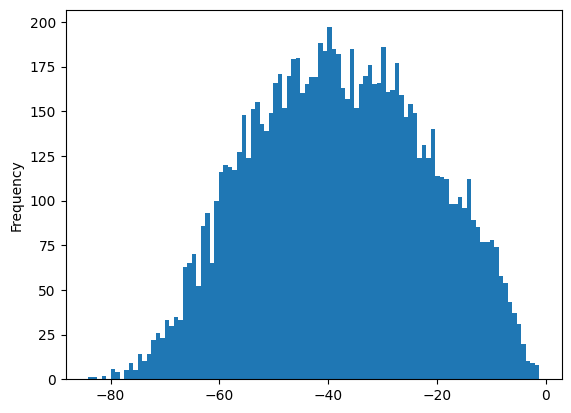

In [30]:
(delta_hedge_daily_trading_cost*np.exp(-r*T)/bsprice(s0,k,T,r,sig)).plot.hist(grid=False,bins=100)

In [31]:
np.mean(delta_hedge_daily_trading_cost)

-126.06629706287393

In [32]:
np.std(delta_hedge_daily_trading_cost)

53.6138289081937

In [33]:
#define PnL function daily
weekly_paths=13
def delta_hedge_weekly_trading_cost(mu,weekly_paths,times,s0,sig,cost):
    dt_weekly = T /weekly_paths
    def sp_paths_weekly(s0,mu,sig,T,weekly_paths,times):
        paths = np.zeros((weekly_paths + 1,times))
        paths[0] = s0
        for i in range(1, weekly_paths + 1):
            paths[i] = paths[i - 1] * np.exp((mu - 0.5 *sig** 2) * dt_weekly + sig * np.sqrt(dt_weekly) * np.random.standard_normal(times))
        return paths
    sp_weekly = sp_paths_weekly(s0,mu,sig,T,weekly_paths,times)
    #initial setting weekly
    initial_delta =  bsdelta(s0,k,T,r,sig)
    initial_shares_weekly = initial_delta * 1 #sell one share of call option
    initial_cost_shares_weekly = initial_shares_weekly * s0
    initial_interest_weekly = initial_cost_shares_weekly * (np.exp(r*dt_weekly)-1)
    initial_hedge_account_weekly = initial_cost_shares_weekly
    expire_time_weekly = np.append((np.ones((weekly_paths, 1)) * dt_weekly).cumsum()[::-1],0)
    delta_weekly = np.zeros((weekly_paths + 1, times))
    shares_weekly = np.zeros((weekly_paths + 1, times))
    cost_shares_weekly = np.zeros((weekly_paths + 1, times))
    hedge_account_weekly = np.zeros((weekly_paths + 1, times))
    interest_weekly = np.zeros((weekly_paths, times))
    
    #delta hedging weekly
    for simulation in range(times):
        for step in range(weekly_paths + 1):
            delta_weekly[0, simulation] = initial_delta
            shares_weekly[0, simulation] = initial_shares_weekly
            cost_shares_weekly[0, simulation] = initial_cost_shares_weekly
            interest_weekly[0, simulation] = initial_interest_weekly
            hedge_account_weekly[0, simulation] = initial_cost_shares_weekly 

            if step in range(1, weekly_paths):
                delta_weekly[step, simulation]=bsdelta(sp_weekly[step,simulation],k,expire_time_weekly[step],r,sig)
                shares_weekly[step,simulation]=abs((delta_weekly[step, simulation]-delta_weekly[step-1, simulation])*1)
                cost_shares_weekly[step,simulation]=shares_weekly[step,simulation]*sp_weekly[step, simulation]
                hedge_account_weekly[step, simulation]=hedge_account_weekly[step-1, simulation]+interest_weekly[step-1, simulation]+cost_shares_weekly[step,simulation]
                interest_weekly[step, simulation] = hedge_account_weekly[step, simulation] * (np.exp(r*dt_weekly)-1)
            if step == weekly_paths:
                if sp_weekly[step, simulation] > k:
                    delta_weekly[step, simulation] = 1
                    shares_weekly[step,simulation]=delta_weekly[step, simulation]-delta_weekly[step-1, simulation]
                    cost_shares_weekly[step,simulation]=shares_weekly[step,simulation]*sp_weekly[step, simulation]
                    hedge_account_weekly[step, simulation]=hedge_account_weekly[step-1, simulation]+cost_shares_weekly[step,simulation]+interest_weekly[step-1, simulation]

                elif sp_weekly[step, simulation] < k:
                    delta_weekly[step, simulation] = 0
                    shares_weekly[step,simulation] = delta_weekly[step, simulation]-delta_weekly[step - 1, simulation]
                    cost_shares_weekly[step,simulation] = \
                    shares_weekly[step,simulation] * sp_weekly[step, simulation]
                    hedge_account_weekly[step, simulation]=hedge_account_weekly[step-1, simulation]+cost_shares_weekly[step,simulation] + interest_weekly[step-1, simulation]

                else:
                    delta_weekly[step, simulation] = 0.5
                    shares_weekly[step,simulation]=delta_weekly[step, simulation] - delta_weekly[step - 1, simulation]
                    cost_shares_weekly[step,simulation]=shares_weekly[step,simulation] * sp_weekly[step, simulation]
                    hedge_account_weekly[step, simulation] = hedge_account_weekly[step-1, simulation]+cost_shares_weekly[step,simulation] + interest_weekly[step-1, simulation]
    delta_weekly = pd.DataFrame(delta_weekly)
    shares_weekly = pd.DataFrame(shares_weekly)
    cost_shares_weekly = pd.DataFrame(cost_shares_weekly)
    hedge_account_weekly = pd.DataFrame(hedge_account_weekly)
    interest_weekly = pd.DataFrame(interest_weekly)
    cum_cost_weekly = hedge_account_weekly.iloc[-1]
    pnl_weekly = np.zeros((1,times))
    for i in range(0,times):
        if sp_weekly[weekly_paths,i] >= k:
            pnl_weekly[0,i] = bsprice(s0,k,T,r,sig)*np.exp(r*T) - (cum_cost_weekly[i]- k)
        elif sp_weekly[weekly_paths,i] < k:
            pnl_weekly[0,i] = bsprice(s0,k,T,r,sig)*np.exp(r*T) - cum_cost_weekly[i]
    df_pnl_weekly = pd.DataFrame(pnl_weekly)
    pnl_weekly = df_pnl_weekly.iloc[-1]
    return pnl_weekly

In [34]:
delta_hedge_weekly_trading_cost=delta_hedge_weekly_trading_cost(mu,weekly_paths,times,s0,sig,0.02)

<AxesSubplot:ylabel='Frequency'>

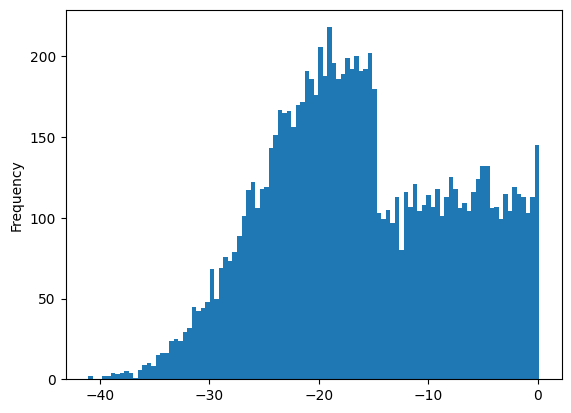

In [35]:
(delta_hedge_weekly_trading_cost*np.exp(-r*T)/bsprice(s0,k,T,r,sig)).plot.hist(grid=False,bins=100)

In [36]:
np.mean(delta_hedge_weekly_trading_cost)

-53.08474090212139

In [37]:
np.std(delta_hedge_weekly_trading_cost)

28.630783930359502

### (b) Does higher rebalancing frequency help? What are the pros and cons of more frequent hedging?

In this situation, it isn't.
Pros: manage the risk of the protfolio and gain less variance
Cons: More operations and more transaction costs.

### (c) Given your simulation results, would the presence of transaction costs impact the price at which you were willing to sell the option to a client?

Yes. I will be more willing to sell the option since I need to waste more trasaction costs if I hold it longer.